<a href="https://colab.research.google.com/github/floudata/apuntes/blob/main/Sesion3_GameIA_BusquedaConInfo_GridHeatMap_Tarea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial - Inteligencia Artificial para Juegos (Game IA) - Sesión 3 - Tarea

<img src='https://www.danielsaromo.xyz/assets/img/logo-pucp.png' width=200px>


Ing. Daniel Saromo, Dr. Edwin Villanueva

<font color='orange'>Entorno del Grid/Laberinto con heurísticas</font>

El objetivo de este notebook es comparar métodos de busqueda ciega y busqueda informada A\*. El ejemplo propuesto es un problema para buscar rutas y así planear las acciones requeridas para el desplazamiento desde un punto a otro en un mapa 2D. La clase MazeSearchProblem necesita ser completada (métodos *actions* y *result*). Deberá implementarse 2 heurísticas para A* (straightline_dist:distancia en linea recta, y manhatan_dist:distancia Manhatan). Despues de implementar ello pruebe las implementaciones con el laberinto `mapa_sesion3.txt`. Al final de este notebook se encuentran algunas preguntas que usted debe contestar.

**Únicamente se requiere completar código en las zonas indicadas (es decir, en: ## TO DO: Completar)**


Completar con su código los campos requeridos y subir su notebook solucionado a la plataforma PAIDEIA. El formato del nombre del notebook es: `Desafio3_APELLIDOPATERNO_NOMBRE.ipynb`. **No subir el archivo del mapa**.

Es responsabilidad del alumno verificar que el archivo que subió es el correcto. Respetar los lineamientos de la entrega de archivo, ya que influirá en su calificación. La fecha límite de entrega del presente desafío se encuentra en PAIDEIA.

## Descarga de archivos hacia el directorio temporal del notebook

In [1]:
!wget -N https://raw.githubusercontent.com/DanielSaromo/Courses_DataFiles/main/GameAI/mapa_sesion3.txt

--2025-01-17 17:20:49--  https://raw.githubusercontent.com/DanielSaromo/Courses_DataFiles/main/GameAI/mapa_sesion3.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503 [text/plain]
Saving to: ‘mapa_sesion3.txt’

mapa_sesion3.txt    100%[===================>]     503  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2025-01-17 17:20:49 (23.0 MB/s) - ‘mapa_sesion3.txt’ saved [503/503]



In [2]:
!wget -N https://raw.githubusercontent.com/DanielSaromo/Courses_DataFiles/main/GameAI/mapa_sesion3_long.txt

--2025-01-17 17:20:53--  https://raw.githubusercontent.com/DanielSaromo/Courses_DataFiles/main/GameAI/mapa_sesion3_long.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503 [text/plain]
Saving to: ‘mapa_sesion3_long.txt’

mapa_sesion3_long.t 100%[===================>]     503  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2025-01-17 17:20:53 (19.1 MB/s) - ‘mapa_sesion3_long.txt’ saved [503/503]



## Definición de entornos

### Clase <b>Maze</b>
La clase Maze es representada por una matriz (grid) de espacios, los cuales pueden estar libres o bloqueados. Cada celda del grid puede tener uno de los siguientes carateres:

    '#': Indica una celda con obstaculo  (impasable)
    '~': Indica una celda con agua (pasable, con costo 5)
    '=': Indica una celda con arena (pasable, con costo 3)
    ' ': Indica una celda vacia (pasable con costo 1)
    'S': Indica la celda de inicio (Start)
    'E': Indica la celda de salida ( End )

In [3]:
class Maze:

    def __init__(self, grid):
        """ Construye el maze a partir del grid ingresado
            grid: debe ser una matriz (lista de listas), ejemplo [['#','S',' '],['#',' ','E']]  """
        self.grid = grid.copy()
        self.numRows = len(grid)
        self.numCols = len(grid[0])
        for i in range(self.numRows):
            for j in range(self.numCols):
                if len(grid[i]) != self.numCols:
                    raise "Grid no es Rectangular"
                if grid[i][j] == 'S':
                    self.startCell = (i,j)
                if grid[i][j] == 'E':
                    self.exitCell= (i,j)
        if self.exitCell == None:
            raise "No hay celda de Inicio"
        if self.startCell == None:
            raise "No hay celda de salida"

    def isPassable(self, row, col):
        """ Retorna true si la celda (row,col) es pasable  (' ' o '~' o '=') """
        return self.isWater(row, col) or self.isSand(row,col) or self.isClear(row, col)

    def isWater(self,row,col):
      return self.grid[row][col] == '~'

    def isSand(self,row,col):
      return self.grid[row][col] == '='

    def isClear(self, row, col):
        """ Retorna true si la celda (row,col) esta vacia  (' ') """
        return self.grid[row][col] == ' '

    def isBlocked(self, row,col):
        """ Retorna true si la celda (row,col) tiene obstaculo ('#') """
        return self.grid[row][col] == '#'

    def getNumRows(self):
        """ Retorna el numero de filas en el maze """
        return self.numRows

    def getNumCols(self):
        """ Retorna el numero de columnas en el maze """
        return self.numCols

    def getStartCell(self):
        """ Retorna la posicion (row,col) de la celda de inicio """
        return self.startCell

    def getExitCell(self):
        """ Retorna la posicion (row,col) de la celda de salida """
        return self.exitCell

    def __getAsciiString(self):
        """ Retorna el string de vizualizacion del maze """
        lines = []
        headerLine = ' ' + ('-' * (self.numCols)) + ' '
        lines.append(headerLine)
        for row in self.grid:
            rowLine = '|' + ''.join(row) + '|'
            lines.append(rowLine)
        lines.append(headerLine)
        return '\n'.join(lines)

    def __str__(self):
        return self.__getAsciiString()

### Funcion para cargar una laberinto de archivo de disco (también reemplazamos `'G'` → `'E'`)

Para hacer que el mapa de la sesión anterior sea compatible con las reglas del entorno de esta semana, debemos reemplazar `'G'` por `'E'`.

In [ ]:
def readMazeFromFile(file):
    """ Lee un archivo que contiene un laberinto y retorna una instancia de Maze con dicho laberinto"""
    fin = open(file)
    lines = fin.read().splitlines()
    grid = []
    for line in lines:
        if G in line:
            print("He reemplazado la casilla con el caracter G por la E")
            line=line.replace("G","E") # https://j2logo.com/string-replace-python/
        grid.append(list(line))
    fin.close()
    return Maze(grid)

## Algoritmos de Búsqueda

### Clase <b>SearchProblem</b>

Esta es una clase abstracta para definir problemas de busqueda. Se debe hacer subclases que implementen los metodos de las acciones, resultados, test de objetivo y el costo de camino. Entonces se puede instanciar las subclases y resolverlos con varias funciones de busqueda.

In [ ]:
class SearchProblem(object):
    def __init__(self, initial, goal=None):
        """Este constructor especifica el estado inicial y posiblemente el estado(s) objetivo(s),
        La subclase puede añadir mas argumentos."""
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Retorna las acciones que pueden ser ejecutadas en el estado dado.
        El resultado es tipicamente una lista."""
        raise NotImplementedError

    def result(self, state, action):
        """Retorna el estado que resulta de ejecutar la accion dada en el estado state.
        La accion debe ser alguna de self.actions(state)."""
        raise NotImplementedError

    def goal_test(self, state):
        """Retorna True si el estado pasado satisface el objetivo."""
        raise NotImplementedError

    def path_cost(self, c, state1, action, state2):
        """Retorna el costo del camino de state2 viniendo de state1 con
        la accion action, asumiendo un costo c para llegar hasta state1.
        El metodo por defecto cuesta 1 para cada paso en el camino."""
        return c + 1

### Clase <b>Node</b>

Estructura de datos para almacenar la informacion de un nodo en un <b>arbol de busqueda</b>. Contiene información del nodo padre y el estado que representa el nodo. Tambien incluye la accion que nos llevo al presente nodo y el costo total del camino desde el nodo raiz hasta este nodo.

In [ ]:
class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0):
        "Crea un nodo de arbol de busqueda, derivado del nodo parent y accion action"
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1

    def expand(self, problem):
        "Devuelve los nodos alcanzables en un paso a partir de este nodo."
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]

    def child_node(self, problem, action):
        next = problem.result(self.state, action)
        return Node(next, self, action,
                    problem.path_cost(self.path_cost, self.state, action, next))

    def solution(self):
        "Retorna la secuencia de acciones para ir de la raiz a este nodo."
        return [node.action for node in self.path()[1:]]

    def path(self):
        "Retorna una lista de nodos formando un camino de la raiz a este nodo."
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    def __lt__(self, node):
        return self.state < node.state

    def __eq__(self, other):
        "Este metodo se ejecuta cuando se compara nodos. Devuelve True cuando los estados son iguales"
        return isinstance(other, Node) and self.state == other.state

    def __repr__(self):
        return "<Node {}>".format(self.state)

    def __hash__(self):
        return hash(self.state)

### <b> Frontera tipo cola FIFO (first-in first out) para BFS</b>

In [ ]:
from collections import deque

class FIFOQueue(deque):
    """Una cola First-In-First-Out"""
    def pop(self):
        return self.popleft()

### <b> Frontera tipo cola de prioridad ordenada por una funcion de costo (para best_first_graph_search y A*)</b>

In [ ]:
import heapq
class FrontierPQ:
    "Una Frontera ordenada por una funcion de costo (Priority Queue)"

    def __init__(self, initial, costfn=lambda node: node.path_cost):
        "Inicializa la Frontera con un nodo inicial y una funcion de costo especificada (por defecto es el costo de camino)."
        self.heap   = []
        self.states = {}
        self.costfn = costfn
        self.add(initial)

    def add(self, node):
        "Agrega un nodo a la frontera."
        cost = self.costfn(node)
        heapq.heappush(self.heap, (cost, node))
        self.states[node.state] = node

    def pop(self):
        "Remueve y retorna el nodo con minimo costo."
        (cost, node) = heapq.heappop(self.heap)
        self.states.pop(node.state, None) # remove state
        return node

    def replace(self, node):
        "node reemplaza al nodo de la Fontera que tiene el mismo estado que node."
        if node.state not in self:
            raise ValueError('{} no tiene nada que reemplazar'.format(node.state))
        for (i, (cost, old_node)) in enumerate(self.heap):
            if old_node.state == node.state:
                self.heap[i] = (self.costfn(node), node)
                heapq._siftdown(self.heap, 0, i)
                return

    def __contains__(self, state): return state in self.states

    def __len__(self): return len(self.heap)

### <b>Algoritmo general de búsqueda con memoria de nodos expandidos (Graph Search)</b>

Algoritmo de general de busqueda ciega con memoria de estados visitados. El argumento frontier debe ser una cola vacia. Si la frontera es tipo FIFO hace busqueda en amplitud (BFS), si la frontera es una pila hará busqueda en profundidad (DFS)

In [ ]:
def graph_search(problem, frontier):
    frontier.append(Node(problem.initial))
    explored = set()     # memoria de estados visitados
    visited_nodes = []   # almacena nodos visitados durante la busqueda
    while frontier:
        node = frontier.pop()
        visited_nodes.append(node)
        if problem.goal_test(node.state):
            return node, visited_nodes
        explored.add(node.state)

        frontier.extend(child for child in node.expand(problem)
                        if child.state not in explored and
                        child not in frontier)
    return None

### <b> Algoritmo Best-First-Graph-Search </b>
Algoritmo general de busqueda con información. La frontera es una cola de prioridad ordenada por la funcion de evaluacion f

In [ ]:
def best_first_graph_search(problem, f):
    """Busca el objetivo expandiendo el nodo de la frontera con el menor valor de la funcion f. Memoriza estados visitados
    Antes de llamar a este algoritmo hay que especificar La funcion f(node). Si f es node.depth tenemos Busqueda en Amplitud;
    si f es node.path_cost tenemos Busqueda  de Costo Uniforme. Si f es una heurística tenemos Busqueda Voraz;
    Si f es node.path_cost + heuristica(node) tenemos A* """

    frontier = FrontierPQ( Node(problem.initial), f )  # frontera tipo cola de prioridad ordenada por f
    explored = set()     # memoria de estados visitados
    visited_nodes = []   # almacena nodos visitados durante la busqueda
    while frontier:
        node = frontier.pop()
        visited_nodes.append(node)
        if problem.goal_test(node.state):
            return node, visited_nodes
        explored.add(node.state)
        for action in problem.actions(node.state):
            child = node.child_node(problem, action)
            if child.state not in explored and child.state not in frontier:
                frontier.add(child)
            elif child.state in frontier:
                incumbent = frontier.states[child.state]
                if f(child) < f(incumbent):
                    frontier.replace(child)

### <b> Algoritmo A* </b>
A* es un caso especial de best_first_graph_search con f = path_cost + heuristic

In [ ]:
def astar_search(problem, heuristic):
    f = lambda node: node.path_cost + heuristic(node, problem)
    return best_first_graph_search(problem, f)

def nullheuristic(node, problem):
    return 0

### Algoritmo de Búsqueda Voraz

In [ ]:
# FUNCIÓN PARA BÚSQUEDA VORAZ (GREEDY SEARCH): AQUÍ USTED DEBE COMPLETAR CÓDIGO

def greedy_search(problem, heuristic):
    f = ... ...: ... + ...
    return ...(..., f)

## <b> Heurísticas para A* </b>
Se debe implementar las heurísticas abajo para A*

In [ ]:
#Para elevar un número a una potencia, se puede usar la libreria math
import math
math.pow(4,2)

16.0

In [ ]:
def straightline_dist(node, problem):
    "Distancia en linea recta desde la celda de node hasta la celda Objetivo (problem.goal)"
    ## TODO: Completar
    print(node.state, problem.goal)

    ##################return ...
    pass

def manhatan_dist(node, problem):
    "Distancia Manhatan (o city block) desde la celda de node hasta la celda Objetivo (problem.goal)"
    ## TODO: Completar

    ##################return ...
    pass

def h_dominante(node, problem):
    "Heurística que domina a las heurísticas cuantificadas por las distancias `straightline_dist` y `manhatan_dist`."
    ## TODO: Completar


    ##################return ...
    pass

In [ ]:
def h_weighted(node, problem, W=5, h_base = straightline_dist):
    # pongo straightline_dist en lugar de manh, porque
    # en este entorno eucl explora más nodos, y se ve más el efecto de usar W
    "Heurística que domina a las heurísticas cuantificadas por las distancias `straightline_dist` y `manhatan_dist`."
    return W * h_base(node, problem)

## Clases para el entorno maze 2D

###  <b> Clase MazeSearchProblem </b>  
Esta es una subclase de SearchProblem que implementa concretamente el problema de busqueda en laberinto. El constructor recibe el laberinto en un objeto maze. Cada estado es codificado como una tupla (row,col) representando la posicion de una celda del grid. El estado inicial es la celda de inicio y el único estado objetivo es la celda de salida.
Se necesita completar Actions (acciones legales para un estado dado) y result (que hacen las acciones).

In [ ]:
class MazeSearchProblem(SearchProblem):
    def __init__(self, maze):
        """El constructor recibe el maze"""
        self.maze = maze
        self.initial = maze.getStartCell()
        self.goal = maze.getExitCell()
        self.numNodesExpanded = 0
        self.expandedNodeSet = {}

    def __isValidState(self,state):
        """ Retorna true si el estado dado corresponde a una celda no bloqueada valida """
        row,col = state
        if row < 0 or row >= self.maze.getNumRows():
            return False
        if col < 0 or col >= self.maze.getNumCols():
            return False
        return not self.maze.isBlocked(row,col)

    def actions(self, state):
        """Retorna las acciones legales desde la celda actual """
        row,col = state
        acciones = []

        if self.__isValidState((row-1, col)):
          acciones.append('N')
        if self.__isValidState((row, col+1)):
          acciones.append('E')
        if self.__isValidState((row+1, col)):
          acciones.append('S')
        if self.__isValidState((row, col-1)):
          acciones.append('W')

        return acciones

    def result(self, state, action):
        """Retorna el estado que resulta de ejecutar la accion dada desde la celda actual.
        La accion debe ser alguna de self.actions(state)"""
        row,col = state
        newState = ()
        if action == 'N':
            newState = (row-1, col)
        ## TO DO: Completar
        if action == 'S':
            newState = (row+1, col)
        if action == 'W':
            newState = (row, col-1)
        if action == 'E':
            newState = (row, col+1)
        ##################
        return newState

    def goal_test(self, state):
        """Retorna True si state es self.goal"""
        return (self.goal == state)

    def path_cost(self, c, state1, action, state2):
        """Retorna el costo del camino de state2 viniendo de state1 con la accion action
        El costo del camino para llegar a state1 es c. El costo de la accion sale de self.maze """
        row, col = state2
        actionCost = None

        ## TO DO: Completar
        ## Defina el valor de la variable actionCost, de acuerdo al tipo de celda (con agua,
        ## con arena o vacía). Por ejemplo, si es una celda con agua, el costo de la accion
        ## es 5. Para esta parte de la implementación, no se requiere verificar que la celda
        ## sea una celda con obstáculo ('#').
        if   self.maze.grid[row][col] == ' ':
            actionCost = 1 #si es una celda vacía, el costo de la accion es 1
        elif self.maze.grid[row][col] == '~':
            actionCost = 5 #si es una celda con agua, el costo de la accion es 5
        elif self.maze.grid[row][col] == '=':
            actionCost = 3 #si es una celda con arena, el costo de la accion es 3
        ##################

        if state2 == self.maze.getStartCell() or state2 == self.maze.getExitCell():
            actionCost = 1

        return c + actionCost

### <b> Funcion para mostrar los resultados </b>

In [ ]:
def displayResults(maze, visitedNodes, solutionNodes):
    """ Muestra los resultados de busqueda en el maze.   """
    grid_copy = []
    for row in maze.grid:
        grid_copy.append([x for x in row])
    for node in visitedNodes:
        row,col = node.state
        ch = maze.grid[row][col]
        if ch != 'S' and ch != 'E': grid_copy[row][col] = 'o'
    for node in solutionNodes:
        row,col = node.state
        ch = maze.grid[row][col]
        if ch != 'S' and ch != 'E': grid_copy[row][col] = 'x'
    maze_copy = Maze(grid_copy)
    print (maze_copy)
    print ("x - celdas en la solucion")
    print ("o - celdas visitadas durante la búsqueda")
    print ("-------------------------------")

### Funciones para conseguir una visualización más didáctica y estilizada

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def convert_maze_toHeatmap(maze_asCharListOfLists, char_to_num, cmap='plasma', fSize=(10, 7)):

    char_list = maze_asCharListOfLists

    # Convert the list of lists of characters to a 2D numpy array of numerical values
    num_array = np.array([[char_to_num[char] for char in sublist] for sublist in char_list])

    lista_wallCharacters = ["#"]
    wall_cells = []

    # Plot the heatmap
    plt.figure(figsize=fSize)
    hMap = sns.heatmap(num_array, annot=False, fmt='d', cmap=cmap, cbar=True,
                xticklabels=False, yticklabels=False)

    # Optional: Add the original characters as annotations
    for i in range(len(char_list)):
        for j in range(len(char_list[i])):
            plt.text(j + 0.5, i + 0.5, char_list[i][j],
                    ha='center', va='center', color='black')

            if char_list[i][j] in lista_wallCharacters: wall_cells.append((i,j))

    # Overlay of the cells that are walls
    for (i, j) in wall_cells:
        hMap.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor='gray', edgecolor='gray'))

    plt.show()

    return num_array

In [ ]:
# Creamos clases para nodos y problemas simulados
class Node_Simulated():
  def __init__(self, state):
    self.state = state

class Problem_Simulated():
  def __init__(self, goal):
    self.goal = goal

In [ ]:
import itertools

def display_pathCosts_ofResults(maze, visitedNodes, solutionNodes, valToPlot='cost',
                            tipoDeBusq=None, hFunc=None, cmap='plasma', addNumericVals=False, fSize=(10, 7)):
    """ Muestra los resultados de path cost luego de realizar la búsqueda en el maze.   """

    title_sufix = "" if tipoDeBusq is None else "Alg. de Búsq.: %s - " % (tipoDeBusq)

    grid_ofPathCosts = []
    solution_path_cells = []

    lista_wallCharacters = ["#"]
    wall_cells = []

    grid_ofHeuristicVals = []
    goal_state = solutionNodes[-1].state # visited_nodes[-1] and solutionNodes[-1] should result in the same state

    for i, row in enumerate(maze.grid):
        grid_ofPathCosts.append([np.nan for x in row])
        grid_ofHeuristicVals.append([np.nan for x in row])
        wall_cells.append([(i,j) for j, x in enumerate(row) if x in lista_wallCharacters])

    # https://stackoverflow.com/questions/952914/how-do-i-make-a-flat-list-out-of-a-list-of-lists
    wall_cells = list(itertools.chain.from_iterable(wall_cells))

    for node in visitedNodes:

        row,col = node.state
        path_cost_ofThisNode = node.path_cost
        grid_ofPathCosts[row][col] = path_cost_ofThisNode

        heuristic_value_ofThisNode = hFunc(Node_Simulated(node.state),
                                                    Problem_Simulated(goal_state)) if hFunc is not None else 0
        grid_ofHeuristicVals[row][col] = round(heuristic_value_ofThisNode, 1)
    for node in solutionNodes:
        row,col = node.state
        solution_path_cells.append( (row, col) )

    grid_ofPathCosts = np.array(grid_ofPathCosts)
    grid_ofHeuristicVals = np.array(grid_ofHeuristicVals)

    # Inicio del Ploteo
    plt.figure(figsize=fSize)

    if valToPlot=='cost':
        plt.title(title_sufix+"Heatmap de: Costo de Acciones (g)")
        gridMovil = grid_ofPathCosts

    elif valToPlot=='heuristic':
        plt.title(title_sufix+"Heatmap de: Heurística (h)")
        gridMovil = grid_ofHeuristicVals

    elif valToPlot=='evalFun':
        plt.title(title_sufix+"Heatmap de: Evaluation Function (f = g + h)")
        gridMovil = grid_ofPathCosts + grid_ofHeuristicVals

    else:
        raise ValueError("%s must be in ['cost', 'heuristic', 'evalFun']")

    # https://stackoverflow.com/questions/74415190/how-to-have-only-int-annotations-in-seaborn-heatmap
    hMap = sns.heatmap(gridMovil, annot=False, cmap=cmap, cbar=True,
                xticklabels=False, yticklabels=False)

    # Optional: Add the values as text
    if addNumericVals:
        for i in range(len(gridMovil)):
            for j in range(len(gridMovil[i])):
                plt.text(j + 0.5, i + 0.5, gridMovil[i][j],
                        ha='center', va='center', color='black', fontsize='xx-small')

    # Overlay of the cells that are walls
    for (i, j) in wall_cells:
        hMap.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor='gray', edgecolor='gray'))

    # Overlay of the cells that belong to the solution path found
    for (i, j) in solution_path_cells:
        hMap.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, lw=0.5, edgecolor='black'))

    # Overlay of the start and end cells:
    hMap.add_patch(plt.Rectangle(solution_path_cells[ 0][::-1], 1, 1, fill=False,
                                 lw=2, linestyle = ':', edgecolor='red'))
    hMap.add_patch(plt.Rectangle(solution_path_cells[-1][::-1], 1, 1, fill=False,
                                 lw=2, linestyle = '-', edgecolor='red'))

    plt.show()

    return grid_ofPathCosts, grid_ofHeuristicVals

## <b> Experimentación con los algoritmos de Busqueda</b>


Recordando la nomenclatura del entorno:

    '#': Indica una celda con obstaculo  (impasable)
    '~': Indica una celda con agua (pasable, con costo 5)
    '=': Indica una celda con arena (pasable, con costo 3)
    ' ': Indica una celda vacia (pasable con costo 1)
    'S': Indica la celda de inicio (Start)
    'E': Indica la celda de salida ( End )

In [ ]:
""" Carga un laberinto de archivo en disco e instancia el problema de busqueda.   """
maze = readMazeFromFile('mapa_sesion3.txt')
p = MazeSearchProblem(maze)
print(maze)

 --------------------------- 
|#################~~~~~~~~~~|
|#################    =~   #|
|     ~~~~    ==   =~==~   #|
|     ~~S~~  ====  ==~=~~  #|
|     ===~~   #==   =~=~~  #|
|     ===~~  ###    =~     #|
|     ===~~  ##   ###~     #|
| =~              ## ~   ###|
| =~      ##  == =~ =E   ###|
|      ==###  == =~      ###|
|##########   ==        ~###|
|~~~~~~~~         ~~~~##~   |
| ### # # ### ### ====##=   |
| # # # # #   # #   ==~~~=  |
| ### # # #   ###   =~~~==  |
| #   # # #   #     =##~    |
| #   ### ### #     =##     |
|~~~~~~~~~~~~~~~~~~~~~~~~~~~|
 --------------------------- 


In [ ]:
maze.grid

[['#',
  '#',
  '#',
  '#',
  '#',
  '#',
  '#',
  '#',
  '#',
  '#',
  '#',
  '#',
  '#',
  '#',
  '#',
  '#',
  '#',
  '~',
  '~',
  '~',
  '~',
  '~',
  '~',
  '~',
  '~',
  '~',
  '~'],
 ['#',
  '#',
  '#',
  '#',
  '#',
  '#',
  '#',
  '#',
  '#',
  '#',
  '#',
  '#',
  '#',
  '#',
  '#',
  '#',
  '#',
  ' ',
  ' ',
  ' ',
  ' ',
  '=',
  '~',
  ' ',
  ' ',
  ' ',
  '#'],
 [' ',
  ' ',
  ' ',
  ' ',
  ' ',
  '~',
  '~',
  '~',
  '~',
  ' ',
  ' ',
  ' ',
  ' ',
  '=',
  '=',
  ' ',
  ' ',
  ' ',
  '=',
  '~',
  '=',
  '=',
  '~',
  ' ',
  ' ',
  ' ',
  '#'],
 [' ',
  ' ',
  ' ',
  ' ',
  ' ',
  '~',
  '~',
  'S',
  '~',
  '~',
  ' ',
  ' ',
  '=',
  '=',
  '=',
  '=',
  ' ',
  ' ',
  '=',
  '=',
  '~',
  '=',
  '~',
  '~',
  ' ',
  ' ',
  '#'],
 [' ',
  ' ',
  ' ',
  ' ',
  ' ',
  '=',
  '=',
  '=',
  '~',
  '~',
  ' ',
  ' ',
  ' ',
  '#',
  '=',
  '=',
  ' ',
  ' ',
  ' ',
  '=',
  '~',
  '=',
  '~',
  '~',
  ' ',
  ' ',
  '#'],
 [' ',
  ' ',
  ' ',
  ' ',
  ' ',
  '=',
  '=',
 

In [ ]:
# Sample list of lists of characters
char_list = [
    [' ', ' ', '='],
    ['S', '~', '='],
    ['E', ' ', '#']
]

# Create a mapping from characters to numerical values
char_to_num = {
    ' ': 1,
    '~': 3,
    '=': 5,
    '#': np.nan,
    'S': 0,
    'E': 0,
}

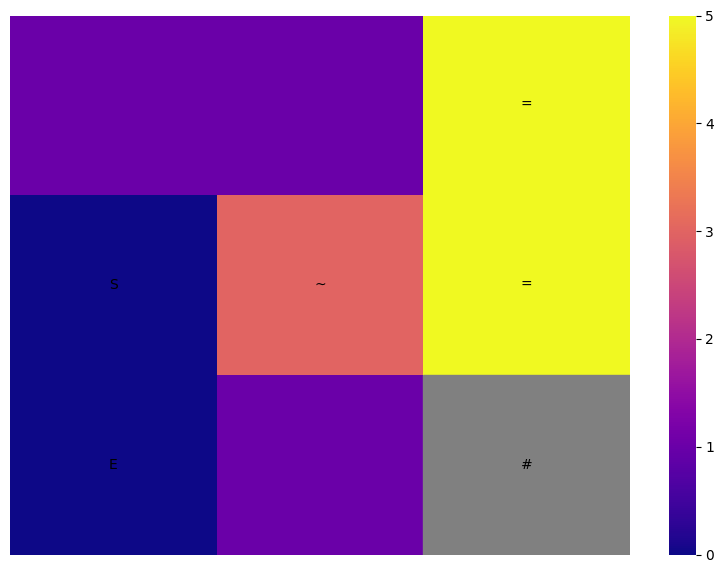

array([[ 1.,  1.,  5.],
       [ 0.,  3.,  5.],
       [ 0.,  1., nan]])

In [ ]:
convert_maze_toHeatmap(char_list, char_to_num) # ejm para entender cómo funciona el ploteador

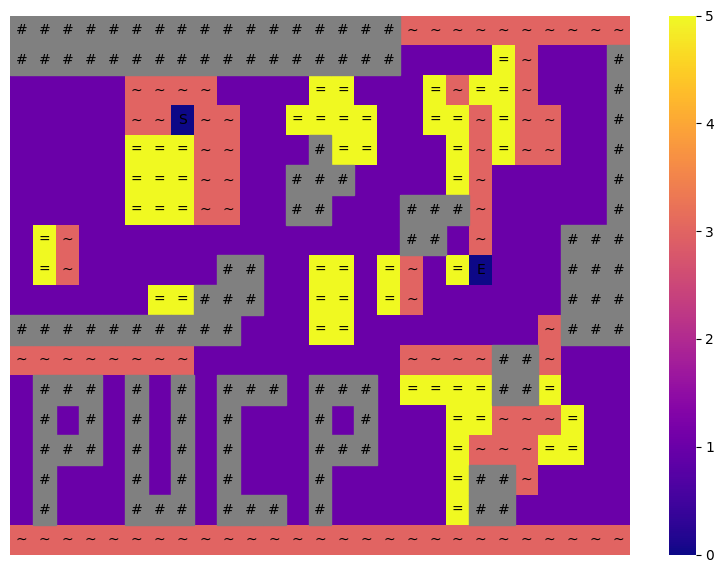

In [ ]:
_ = convert_maze_toHeatmap(maze.grid, char_to_num)

### 👨‍🦯 Algoritmos de búsqueda SIN información

#### busqueda en amplitud (BFS)

In [ ]:
nsol, visited_nodes = graph_search(p, FIFOQueue())
print('Solucion BFS: {}. Nodos visitados={}. Costo Solucion = {}'.format(nsol.solution(), len(visited_nodes),nsol.path_cost))
displayResults(maze, visited_nodes, nsol.path())

Solucion BFS: ['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'S', 'S', 'S', 'S', 'S']. Nodos visitados=209. Costo Solucion = 58
 --------------------------- 
|#################oooooo~~~~|
|#################ooooooo  #|
|ooooooooooooooooooooooooo #|
|oooooooSxxxxxxxxxxxxxooooo#|
|ooooooooooooo#ooooooxoooo #|
|oooooooooooo###oooooxooo  #|
|oooooooooooo##ooo###xoo   #|
|ooooooooooooooooo## xo  ###|
|ooooooooo##oooooooooE   ###|
|oooooooo###oooooooo     ###|
|##########oooooooo     ~###|
|~~~~~~ooooooooooo~~~~##~   |
| ### # #o###o### ====##=   |
| # # # #o#ooo# #   ==~~~=  |
| ### # # # oo###   =~~~==  |
| #   # # #  o#     =##~    |
| #   ### ### #     =##     |
|~~~~~~~~~~~~~~~~~~~~~~~~~~~|
 --------------------------- 
x - celdas en la solucion
o - celdas visitadas durante la búsqueda
-------------------------------


In [ ]:
# Vamos a guardar los resultados obtenidos con BFS, para comparar las gráficas de las heurísticas
# por qué elegimos guardar los resultados de BFS, y no de otro algoritmo? responder luego de ver UCS
import copy
nsol_BFS, visited_nodes_BFS = copy.deepcopy(nsol), copy.deepcopy(visited_nodes)

##### Veamos los resultados de nuestro experimento

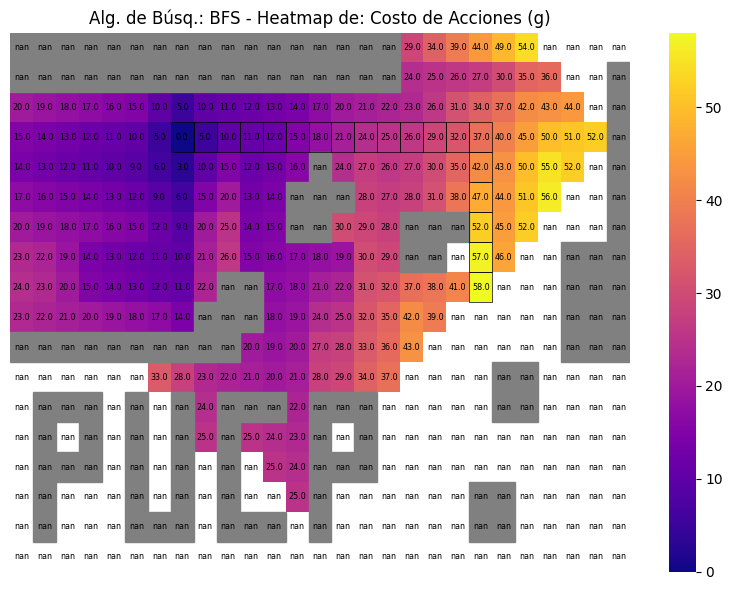

In [ ]:
costiGrid, heuriGrid = display_pathCosts_ofResults(maze, visited_nodes, nsol.path(), tipoDeBusq='BFS',
                                            valToPlot="cost", hFunc=None, addNumericVals=True)

Por qué el agente no decidió ir hacia abajo en su primer movimiento?

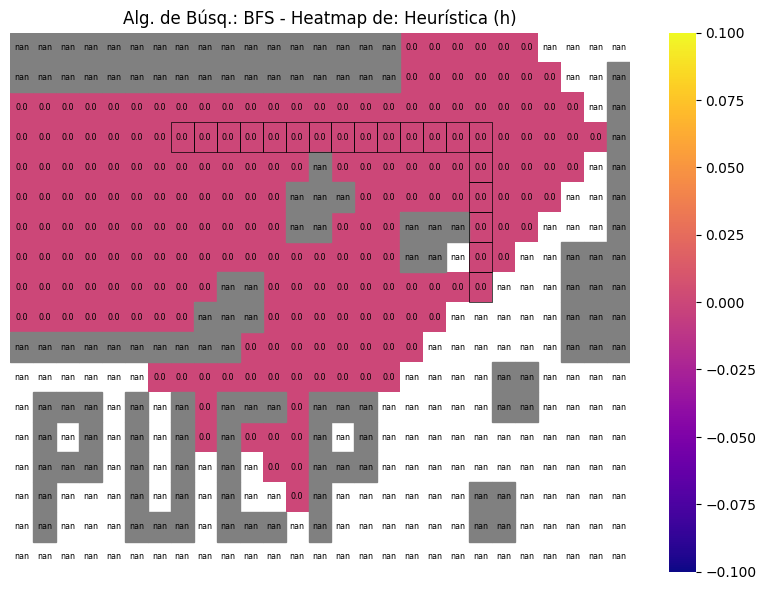

In [ ]:
costiGrid, heuriGrid = display_pathCosts_ofResults(maze, visited_nodes, nsol.path(), tipoDeBusq='BFS',
                                            valToPlot="heuristic", hFunc=None, addNumericVals=True)

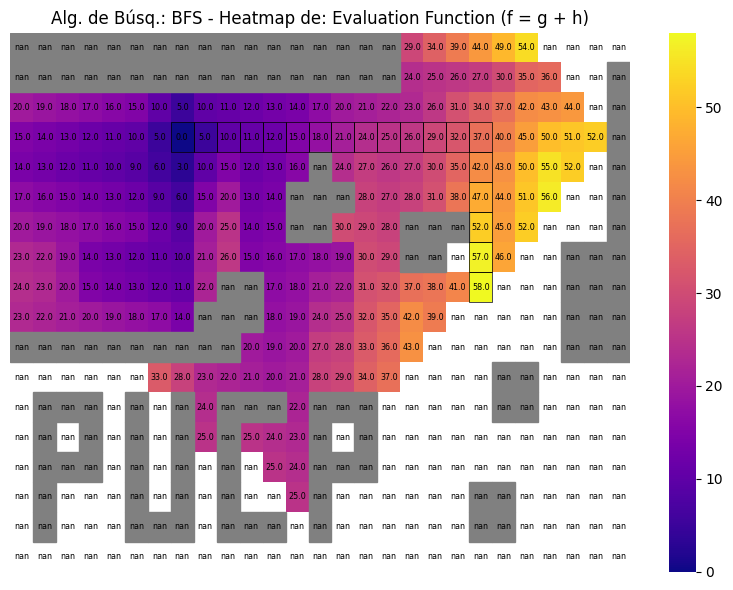

In [ ]:
costiGrid, heuriGrid = display_pathCosts_ofResults(maze, visited_nodes, nsol.path(), tipoDeBusq='BFS',
                                            valToPlot="evalFun", hFunc=None, addNumericVals=True)

#### busqueda en profundidad (DFS)

In [ ]:
nsol, visited_nodes = graph_search(p, [])
print('Solucion DFS: {}. Nodos visitados={}. Costo Solucion = {}'.format(nsol.solution(), len(visited_nodes),nsol.path_cost))
displayResults(maze, visited_nodes, nsol.path())

Solucion DFS: ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'S', 'S', 'S', 'S', 'S', 'S', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'N', 'E', 'N', 'E', 'E', 'E', 'S', 'S', 'S', 'W', 'S', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'S', 'S', 'S', 'S', 'S', 'S', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'N', 'N', 'W', 'W', 'W', 'W', 'N', 'W', 'W', 'W', 'W', 'W', 'W', 'N', 'N', 'E', 'E', 'E', 'E', 'N', 'N', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'N', 'N', 'E', 'E', 'E', 'E', 'E', 'E', 'E']. Nodos visitados=126. Costo Solucion = 310
 --------------------------- 
|#################~~~~~~~~~~|
|#################    =~   #|
|     ~~~~    ==   =~==~   #|
|xxxxxxxS~~  ====  ==~=~~  #|
|x    ===~~   #==   =~=~~  #|
|x    ===~~  ###    =~     #|
|x    ===~~  ##   ###~     #|
|x=~     xxxx     ## ~   ###|
|x=~    xx##x xxxxxxxE   ###|
|xxxxxxxx###x x= =~      ###|
|##########xx xxxxxxxx  ~###|
|xxxxxxxxxxx oo   ~~~x##~   |
|x

##### Veamos los resultados de nuestro experimento

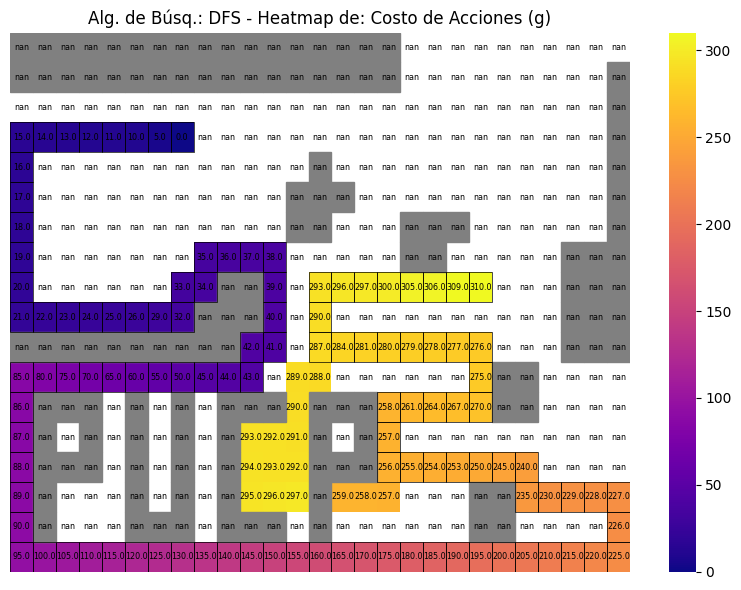

In [ ]:
costiGrid, heuriGrid = display_pathCosts_ofResults(maze, visited_nodes, nsol.path(), tipoDeBusq='DFS',
                                            valToPlot="cost", hFunc=None, addNumericVals=True)

Por qué desde la posición con `g=287.0`, el agente no se movió hacia abajo? A pesar de que 288 tiene menor costo de camino que 290?

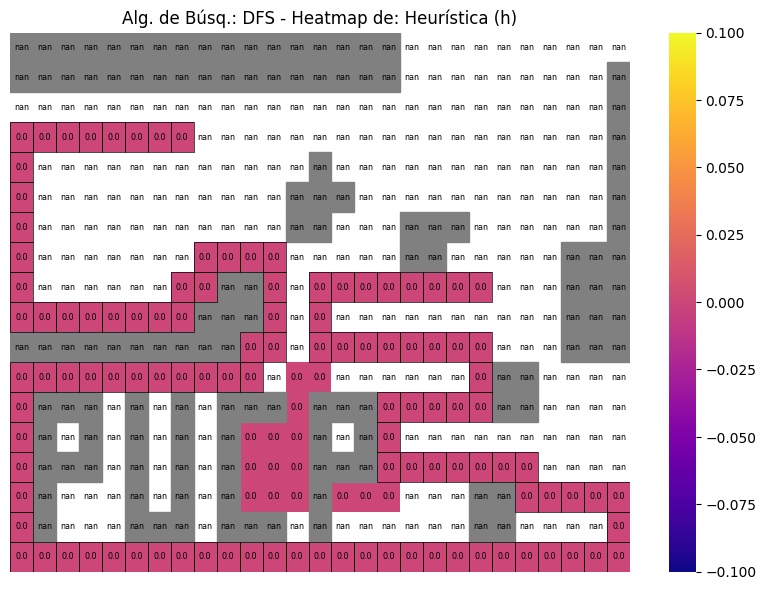

In [ ]:
costiGrid, heuriGrid = display_pathCosts_ofResults(maze, visited_nodes, nsol.path(), tipoDeBusq='DFS',
                                            valToPlot="heuristic", hFunc=None, addNumericVals=True)

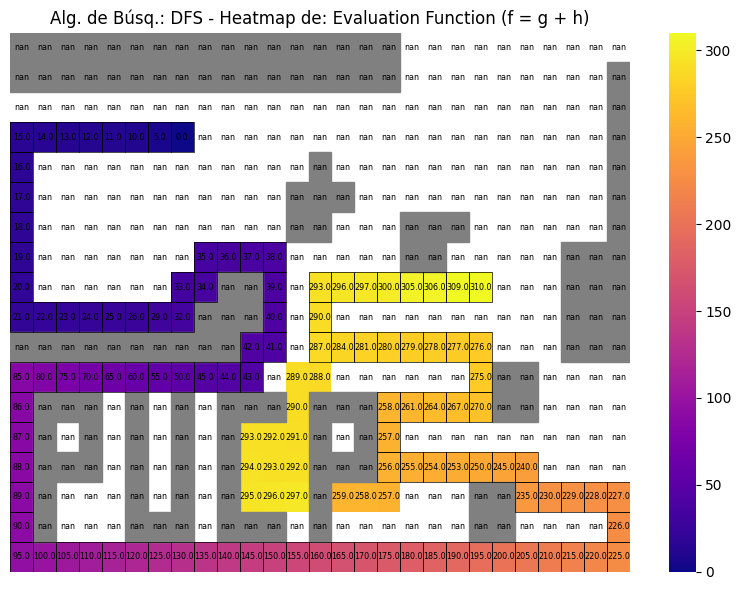

In [ ]:
costiGrid, heuriGrid = display_pathCosts_ofResults(maze, visited_nodes, nsol.path(), tipoDeBusq='DFS',
                                            valToPlot="evalFun", hFunc=None, addNumericVals=True)

#### busqueda A* con heurística nula (UCS)

In [ ]:
nsol, visited_nodes = astar_search(p, nullheuristic)
print('Solucion A* y heuristica nula (UCS): {}. Nodos visitados={}. Costo Solucion = {}'.format(nsol.solution(), len(visited_nodes),nsol.path_cost))
displayResults(maze, visited_nodes, nsol.path())

Solucion A* y heuristica nula (UCS): ['S', 'S', 'S', 'S', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'S', 'S', 'S', 'E', 'E', 'E', 'N', 'E', 'E', 'N']. Nodos visitados=191. Costo Solucion = 28
 --------------------------- 
|#################~~~~~~~~~~|
|#################oooo=~   #|
|ooooooooooooooooooo~==~   #|
|oooooooSooooooooooo=~=~~  #|
|oooooooxooooo#oooooo~=~~  #|
|oooooooxoooo###ooooo~     #|
|oooooooxoooo##ooo###~     #|
|oooooooxxxxxxxxxo## ~   ###|
|ooooooooo##ooooxooo=E   ###|
|oooooooo###ooooxo~xxx   ###|
|##########oooooxxxxooo ~###|
|~~~~~~~oooooooooo~~~~##~   |
| ### # #o###o###oo===##=   |
| # # # #o#ooo# #ooo==~~~=  |
| ### # #o#ooo###oo =~~~==  |
| #   # #o#ooo#  o  =##~    |
| #   ###o###o#     =##     |
|~~~~~~~~~~~~~~~~~~~~~~~~~~~|
 --------------------------- 
x - celdas en la solucion
o - celdas visitadas durante la búsqueda
-------------------------------


##### Veamos los resultados de nuestro experimento

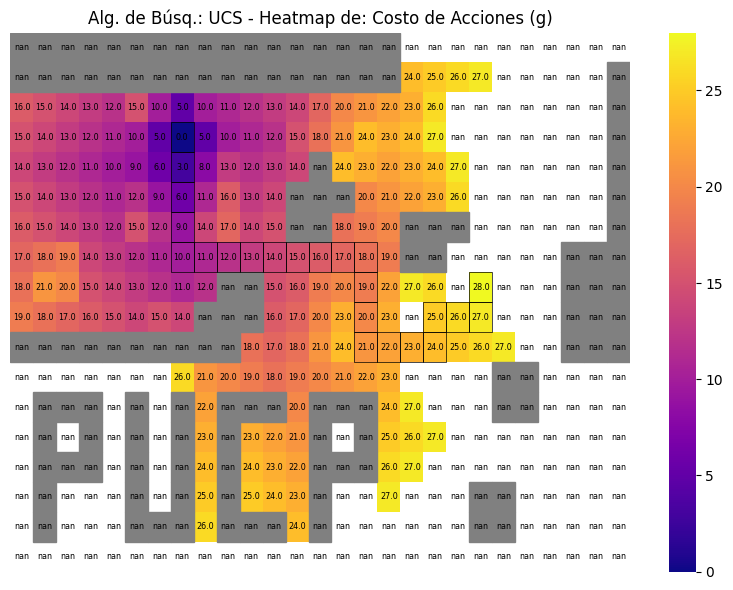

In [ ]:
costiGrid, heuriGrid = display_pathCosts_ofResults(maze, visited_nodes, nsol.path(), tipoDeBusq='UCS',
                                            valToPlot="cost", hFunc=None, addNumericVals=True)

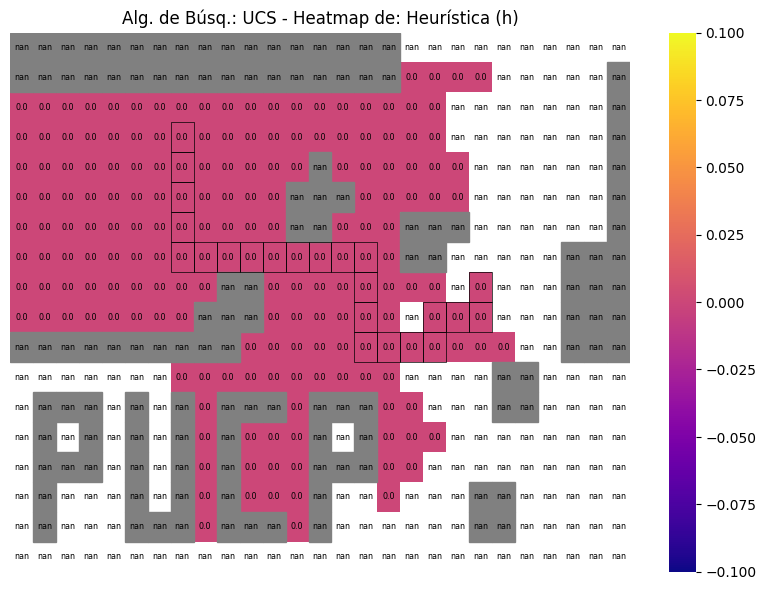

In [ ]:
costiGrid, heuriGrid = display_pathCosts_ofResults(maze, visited_nodes, nsol.path(), tipoDeBusq='UCS',
                                            valToPlot="heuristic", hFunc=None, addNumericVals=True)

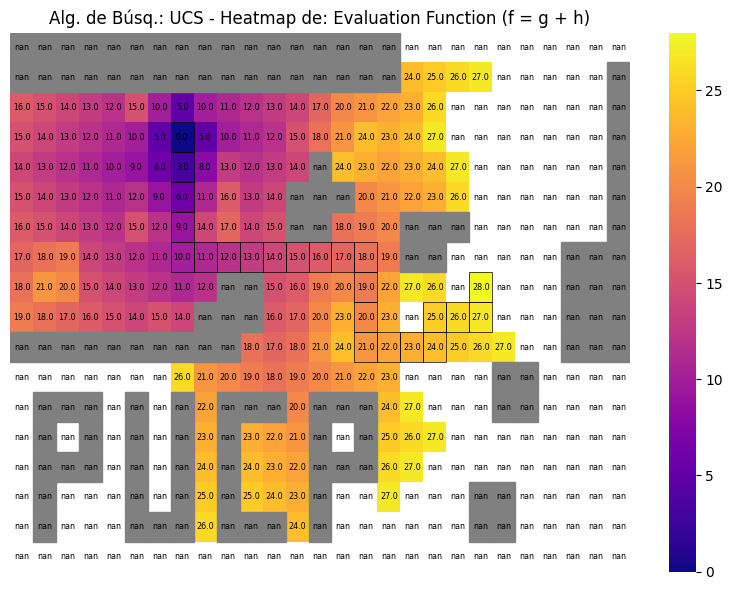

In [ ]:
costiGrid, heuriGrid = display_pathCosts_ofResults(maze, visited_nodes, nsol.path(), tipoDeBusq='UCS',
                                            valToPlot="evalFun", hFunc=None, addNumericVals=True)

### 🔦 Algoritmos de búsqueda CON información

#### Visualización de valores de las heurísticas - Usaremos el Mapa Versión Long

In [ ]:
""" Carga un laberinto de archivo en disco e instancia el problema de busqueda.   """
maze_long = readMazeFromFile('mapa_sesion3_long.txt')
p_long = MazeSearchProblem(maze_long)
print(maze_long)

 --------------------------- 
|#################~~~~~~~~~~|
|#################    =~   #|
|     ~~~~    ==   =~==~   #|
|     ~~S~~  ====  ==~=~~  #|
|     ===~~   #==   =~=~~  #|
|     ===~~  ###    =~     #|
|     ===~~  ##   ###~     #|
| =~              ## ~   ###|
| =~      ##  == =~ =    ###|
|      ==###  == =~      ###|
|##########   ==         ###|
|~~~~~~~~         ~~~~##~   |
| ### # # ### ### ====##=   |
| # # # # #   # #   ==~~~=  |
| ### # # #   ###   =~~~==  |
| #   # # #   #     =##~    |
| #   ### ### #     =##     |
|~~~~~~~~~~~~~~~~~~~~~~~~~~E|
 --------------------------- 


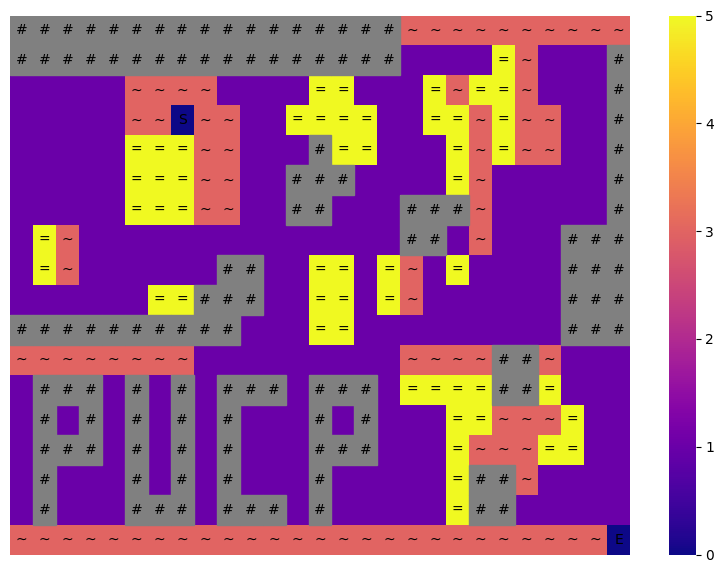

In [ ]:
_ = convert_maze_toHeatmap(maze_long.grid, char_to_num)

In [ ]:
nsol_long, visited_nodes_long = graph_search(p_long, FIFOQueue())

In [ ]:
print('Solucion BFS: {}. Nodos visitados={}. Costo Solucion = {}'.format(nsol_long.solution(), len(visited_nodes_long),nsol_long.path_cost))
displayResults(maze_long, visited_nodes_long, nsol_long.path())

Solucion BFS: ['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'E', 'E', 'E', 'S', 'S', 'S', 'S', 'S', 'S']. Nodos visitados=358. Costo Solucion = 75
 --------------------------- 
|#################oooooooooo|
|#################ooooooooo#|
|oooooooooooooooooooooooooo#|
|oooooooSxxxxxxxxxxxxxxxxoo#|
|ooooooooooooo#oooooooooxoo#|
|oooooooooooo###ooooooooxoo#|
|oooooooooooo##ooo###oooxoo#|
|ooooooooooooooooo##oooox###|
|ooooooooo##oooooooooooox###|
|oooooooo###oooooooooooox###|
|##########ooooooooooooox###|
|ooooooooooooooooooooo##xxxx|
|o###o#o#o###o###ooooo##ooox|
|o# #o#o#o#ooo# #oooooooooox|
|o###o#o#o#ooo###oooooooooox|
|o#ooo#o#o#ooo#oooooo##oooox|
|o#ooo###o###o#oooooo##oooox|
|ooooooooooooooooooooooooooE|
 --------------------------- 
x - celdas en la solucion
o - celdas visitadas durante la búsqueda
-------------------------------


##### Veamos los resultados de nuestro experimento

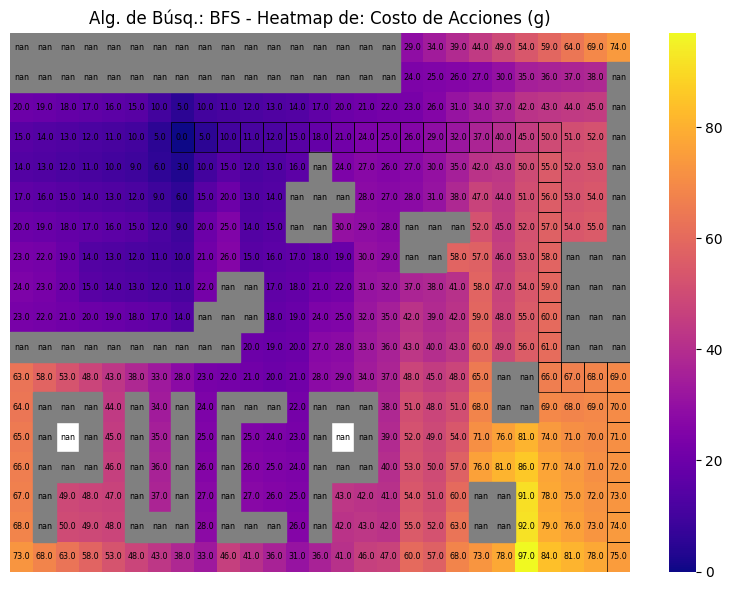

In [ ]:
costiGrid, heuriGrid = display_pathCosts_ofResults(maze_long, visited_nodes_long, nsol_long.path(), tipoDeBusq='BFS',
                                            valToPlot="cost", hFunc=None, addNumericVals=True)

Por qué el agente no decidió ir hacia abajo en su primer movimiento?

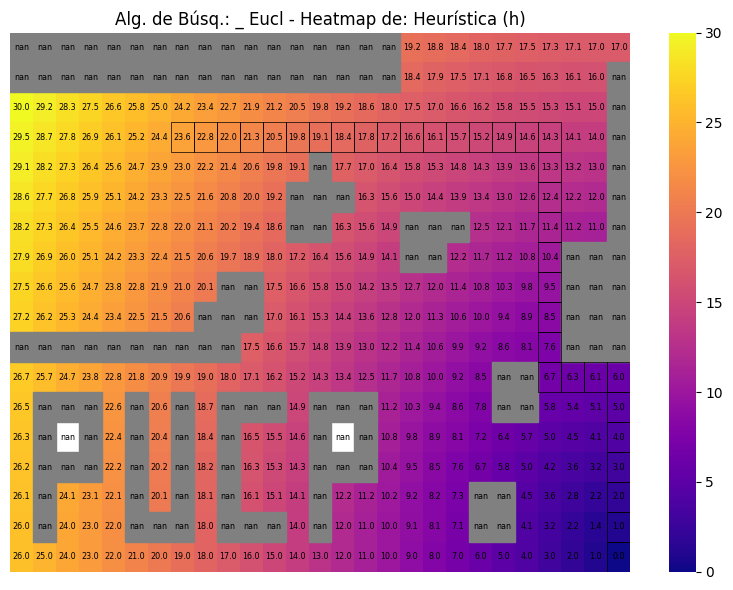

In [ ]:
costiGrid, heuriGrid = display_pathCosts_ofResults(maze_long, visited_nodes_long, nsol_long.path(), tipoDeBusq='_ Eucl',
                                            valToPlot="heuristic", hFunc=straightline_dist, addNumericVals=True)

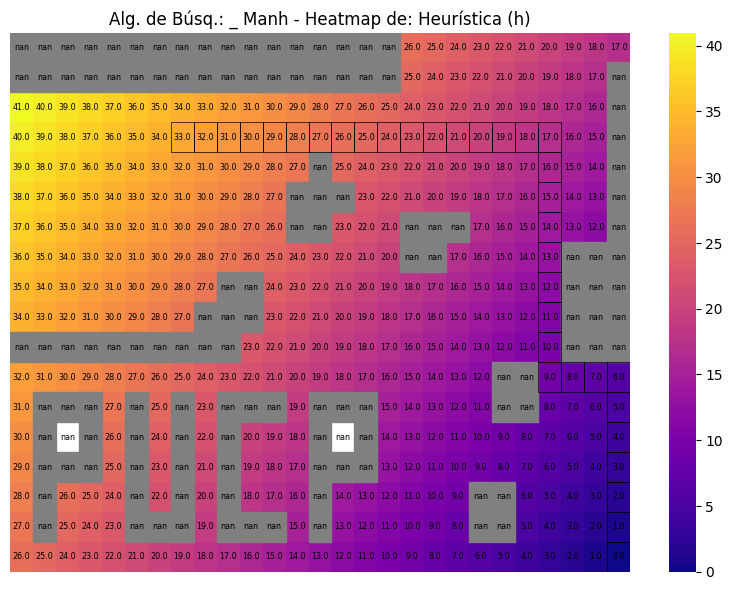

In [ ]:
costiGrid, heuriGrid = display_pathCosts_ofResults(maze_long, visited_nodes_long, nsol_long.path(), tipoDeBusq='_ Manh',
                                            valToPlot="heuristic", hFunc=manhatan_dist, addNumericVals=True)

#### busqueda codiciosa con heurística h_dominante

In [ ]:
nsol, visited_nodes = greedy_search(p, h_dominante)
print('Solucion greedy y heuristica h_dominante: {}. Nodos visitados={}. Costo Solucion = {}'.format(nsol.solution(), len(visited_nodes),nsol.path_cost))
displayResults(maze, visited_nodes, nsol.path())

Solucion greedy y heuristica h_dominante: ['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'S', 'S', 'S', 'S', 'S']. Nodos visitados=19. Costo Solucion = 58
 --------------------------- 
|#################~~~~~~~~~~|
|#################    =~   #|
|     ~~~~    ==   =~==~   #|
|     ~~Sxxxxxxxxxxxxx=~~  #|
|     ===~~   #==   =x=~~  #|
|     ===~~  ###    =x     #|
|     ===~~  ##   ###x     #|
| =~              ## x   ###|
| =~      ##  == =~ =E   ###|
|      ==###  == =~      ###|
|##########   ==        ~###|
|~~~~~~~~         ~~~~##~   |
| ### # # ### ### ====##=   |
| # # # # #   # #   ==~~~=  |
| ### # # #   ###   =~~~==  |
| #   # # #   #     =##~    |
| #   ### ### #     =##     |
|~~~~~~~~~~~~~~~~~~~~~~~~~~~|
 --------------------------- 
x - celdas en la solucion
o - celdas visitadas durante la búsqueda
-------------------------------


##### Veamos los resultados de nuestro experimento

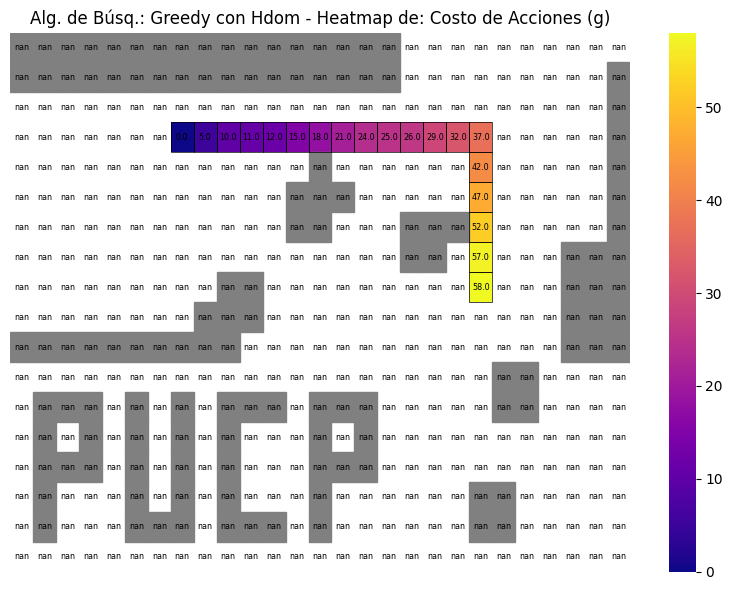

In [ ]:
costiGrid, heuriGrid = display_pathCosts_ofResults(maze, visited_nodes, nsol.path(), tipoDeBusq='Greedy con Hdom',
                                            valToPlot="cost", hFunc=h_dominante, addNumericVals=True)

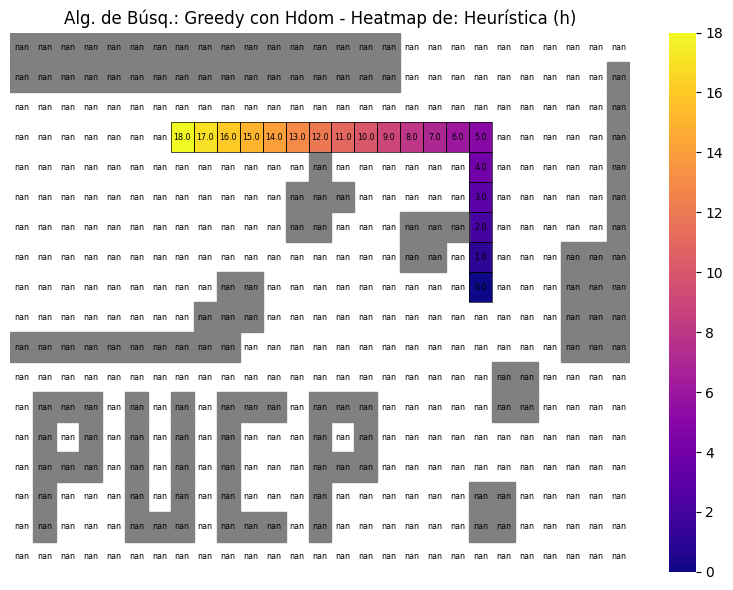

In [ ]:
costiGrid, heuriGrid = display_pathCosts_ofResults(maze, visited_nodes, nsol.path(), tipoDeBusq='Greedy con Hdom',
                                            valToPlot="heuristic", hFunc=h_dominante, addNumericVals=True)

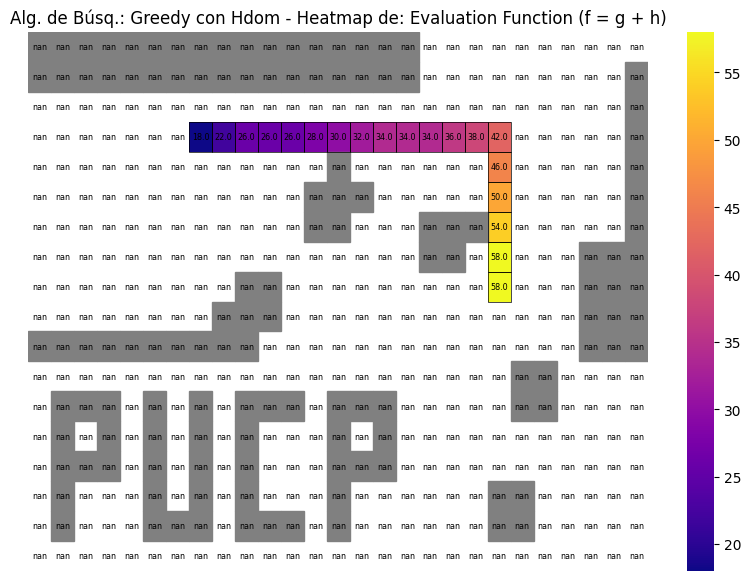

In [ ]:
costiGrid, heuriGrid = display_pathCosts_ofResults(maze, visited_nodes, nsol.path(), tipoDeBusq='Greedy con Hdom',
                                            valToPlot="evalFun", hFunc=h_dominante, addNumericVals=True)

#### busqueda A* con heurística straightline_dist

In [ ]:
nsol, visited_nodes = astar_search(p, straightline_dist)
print('Solucion A* y heuristica straightline_dist: {}. Nodos visitados={}. Costo Solucion = {}'.format(nsol.solution(), len(visited_nodes),nsol.path_cost))
displayResults(maze, visited_nodes, nsol.path())

Solucion A* y heuristica straightline_dist: ['S', 'S', 'S', 'S', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'S', 'S', 'S', 'E', 'E', 'E', 'N', 'E', 'E', 'N']. Nodos visitados=94. Costo Solucion = 28
 --------------------------- 
|#################~~~~~~~~~~|
|#################    =~   #|
|     ~oooooooo=   =~==~   #|
|    oooSoooooo==  ==~=~~  #|
|    oooxooooo#==oo =~=~~  #|
|    oooxoooo###oooo=~     #|
|     =oxo~oo##ooo###~     #|
| =~  ooxxxxxxxxxo## ~   ###|
| =~  oooo##ooooxo~o=E   ###|
|      =o###ooo=xo~xxx   ###|
|########## oo==xxxxo   ~###|
|~~~~~~~~   ooooo ~~~~##~   |
| ### # # ### ### ====##=   |
| # # # # #   # #   ==~~~=  |
| ### # # #   ###   =~~~==  |
| #   # # #   #     =##~    |
| #   ### ### #     =##     |
|~~~~~~~~~~~~~~~~~~~~~~~~~~~|
 --------------------------- 
x - celdas en la solucion
o - celdas visitadas durante la búsqueda
-------------------------------


##### Veamos los resultados de nuestro experimento

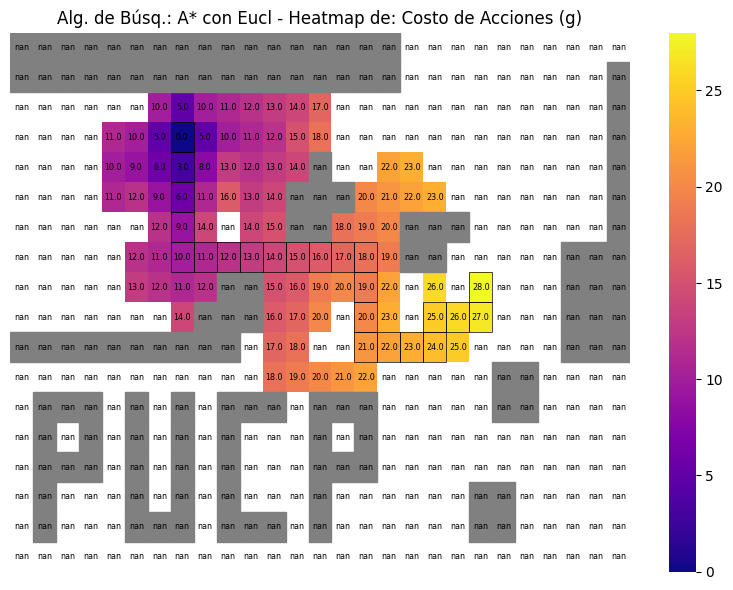

In [ ]:
costiGrid, heuriGrid = display_pathCosts_ofResults(maze, visited_nodes, nsol.path(), tipoDeBusq='A* con Eucl',
                                            valToPlot="cost", hFunc=straightline_dist, addNumericVals=True)

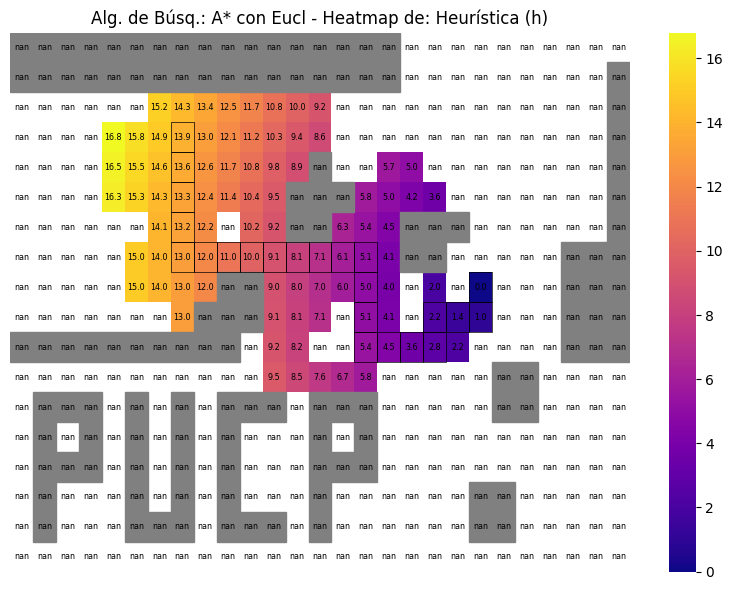

In [ ]:
costiGrid, heuriGrid = display_pathCosts_ofResults(maze, visited_nodes, nsol.path(), tipoDeBusq='A* con Eucl',
                                            valToPlot="heuristic", hFunc=straightline_dist, addNumericVals=True)

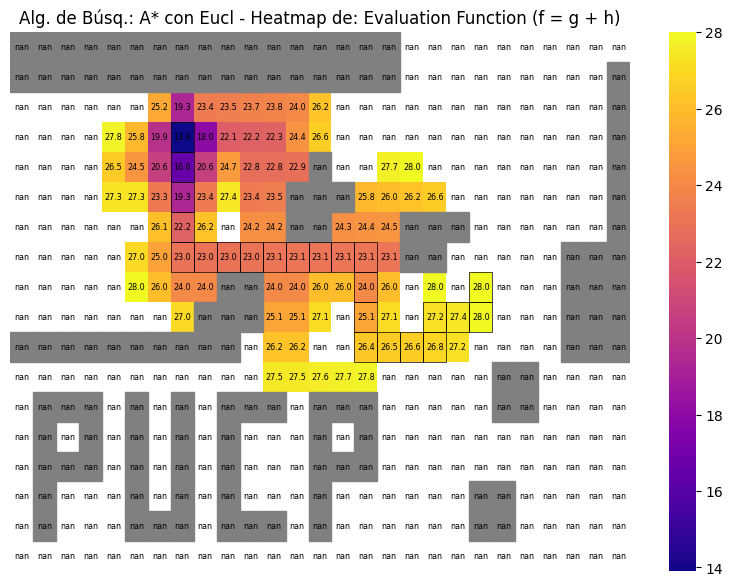

In [ ]:
costiGrid, heuriGrid = display_pathCosts_ofResults(maze, visited_nodes, nsol.path(), tipoDeBusq='A* con Eucl',
                                            valToPlot="evalFun", hFunc=straightline_dist, addNumericVals=True)

#### busqueda A* con heurística manhatan_dist

In [ ]:
nsol, visited_nodes = astar_search(p, manhatan_dist)
print('Solucion A* y heuristica manhatan_dist: {}. Nodos visitados={}. Costo Solucion = {}'.format(nsol.solution(), len(visited_nodes),nsol.path_cost))
displayResults(maze, visited_nodes, nsol.path())

Solucion A* y heuristica manhatan_dist: ['S', 'S', 'S', 'S', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'S', 'S', 'S', 'E', 'E', 'E', 'N', 'E', 'E', 'N']. Nodos visitados=77. Costo Solucion = 28
 --------------------------- 
|#################~~~~~~~~~~|
|#################    =~   #|
|     ~~oooooo==   =~==~   #|
|     ~oSooooo===  ==~=~~  #|
|     ooxooooo#==   =~=~~  #|
|     =oxo~oo###oooo=~     #|
|     =oxo~oo##ooo###~     #|
| =~  ooxxxxxxxxxo## ~   ###|
| =~  oooo##ooooxo~o=E   ###|
|      =o###ooo=xo~xxx   ###|
|########## oo==xxxx    ~###|
|~~~~~~~~         ~~~~##~   |
| ### # # ### ### ====##=   |
| # # # # #   # #   ==~~~=  |
| ### # # #   ###   =~~~==  |
| #   # # #   #     =##~    |
| #   ### ### #     =##     |
|~~~~~~~~~~~~~~~~~~~~~~~~~~~|
 --------------------------- 
x - celdas en la solucion
o - celdas visitadas durante la búsqueda
-------------------------------


##### Veamos los resultados de nuestro experimento

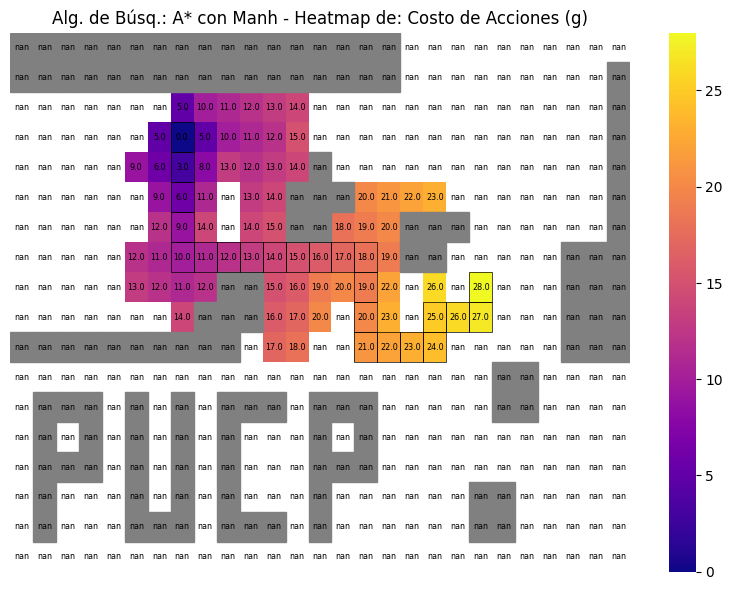

In [ ]:
costiGrid, heuriGrid = display_pathCosts_ofResults(maze, visited_nodes, nsol.path(), tipoDeBusq='A* con Manh',
                                            valToPlot="cost", hFunc=manhatan_dist, addNumericVals=True)

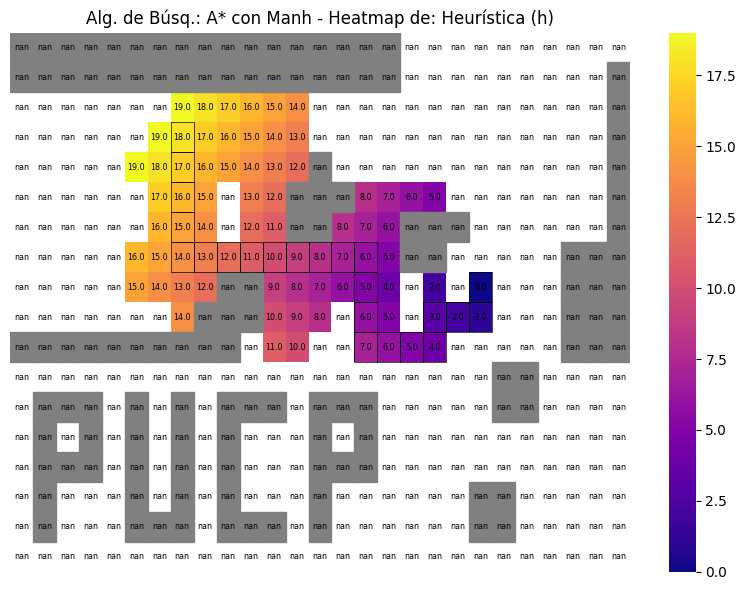

In [ ]:
costiGrid, heuriGrid = display_pathCosts_ofResults(maze, visited_nodes, nsol.path(), tipoDeBusq='A* con Manh',
                                            valToPlot="heuristic", hFunc=manhatan_dist, addNumericVals=True)

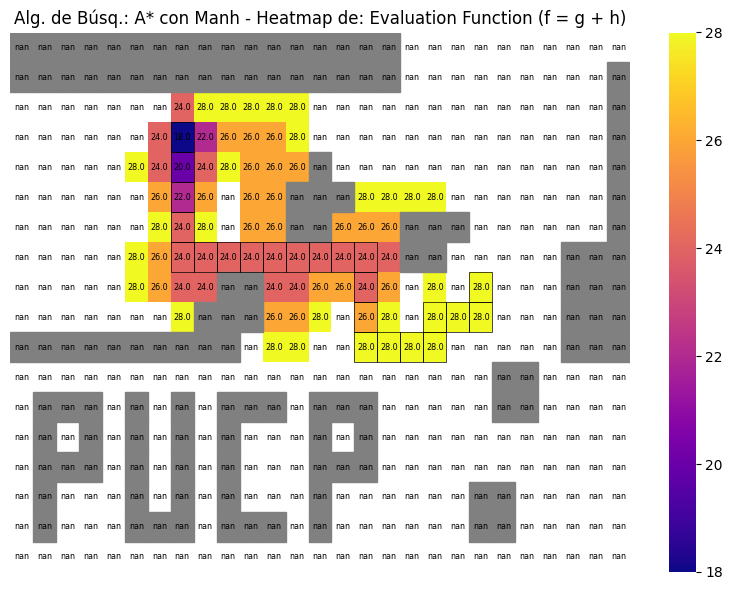

In [ ]:
costiGrid, heuriGrid = display_pathCosts_ofResults(maze, visited_nodes, nsol.path(), tipoDeBusq='A* con Manh',
                                            valToPlot="evalFun", hFunc=manhatan_dist, addNumericVals=True)

#### busqueda A* con heurística h_dominante

In [ ]:
nsol, visited_nodes = astar_search(p, h_dominante)
print('Solucion A* y heuristica h_dominante: {}. Nodos visitados={}. Costo Solucion = {}'.format(nsol.solution(), len(visited_nodes),nsol.path_cost))
displayResults(maze, visited_nodes, nsol.path())

Solucion A* y heuristica h_dominante: ['S', 'S', 'S', 'S', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'S', 'S', 'S', 'E', 'E', 'E', 'N', 'E', 'E', 'N']. Nodos visitados=77. Costo Solucion = 28
 --------------------------- 
|#################~~~~~~~~~~|
|#################    =~   #|
|     ~~oooooo==   =~==~   #|
|     ~oSooooo===  ==~=~~  #|
|     ooxooooo#==   =~=~~  #|
|     =oxo~oo###oooo=~     #|
|     =oxo~oo##ooo###~     #|
| =~  ooxxxxxxxxxo## ~   ###|
| =~  oooo##ooooxo~o=E   ###|
|      =o###ooo=xo~xxx   ###|
|########## oo==xxxx    ~###|
|~~~~~~~~         ~~~~##~   |
| ### # # ### ### ====##=   |
| # # # # #   # #   ==~~~=  |
| ### # # #   ###   =~~~==  |
| #   # # #   #     =##~    |
| #   ### ### #     =##     |
|~~~~~~~~~~~~~~~~~~~~~~~~~~~|
 --------------------------- 
x - celdas en la solucion
o - celdas visitadas durante la búsqueda
-------------------------------


##### Veamos los resultados de nuestro experimento

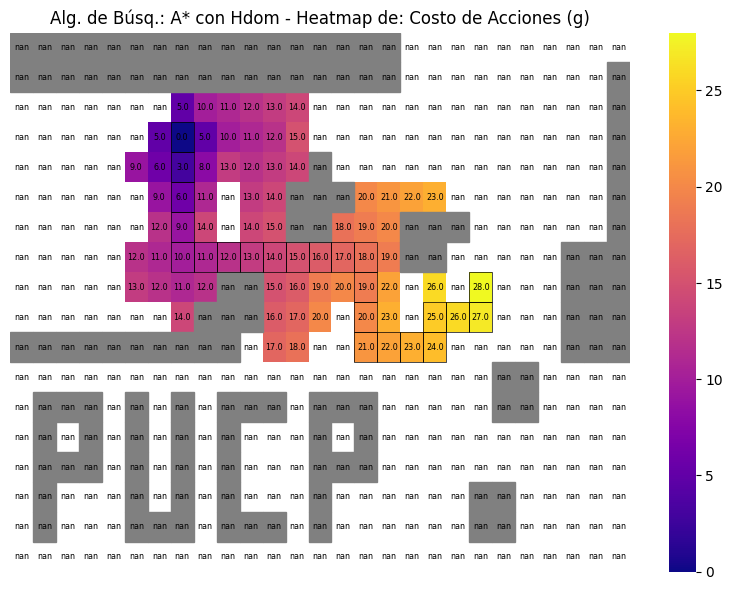

In [ ]:
costiGrid, heuriGrid = display_pathCosts_ofResults(maze, visited_nodes, nsol.path(), tipoDeBusq='A* con Hdom',
                                            valToPlot="cost", hFunc=h_dominante, addNumericVals=True)

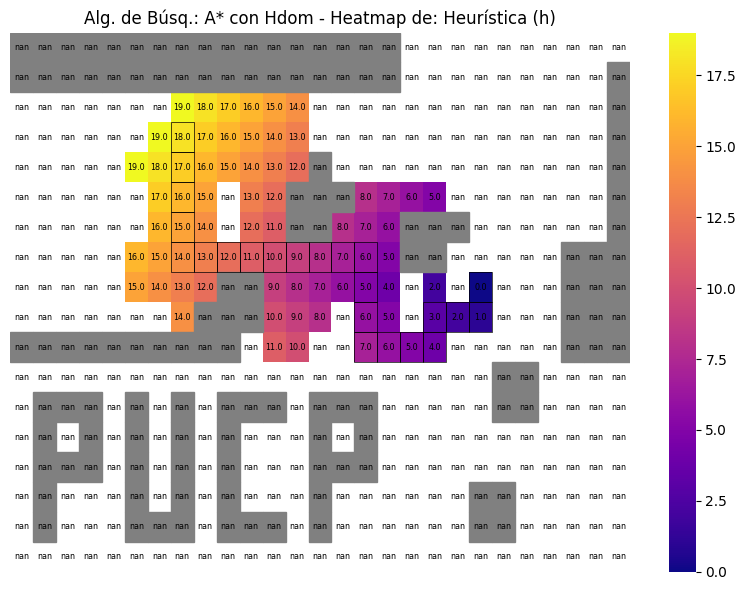

In [ ]:
costiGrid, heuriGrid = display_pathCosts_ofResults(maze, visited_nodes, nsol.path(), tipoDeBusq='A* con Hdom',
                                            valToPlot="heuristic", hFunc=h_dominante, addNumericVals=True)

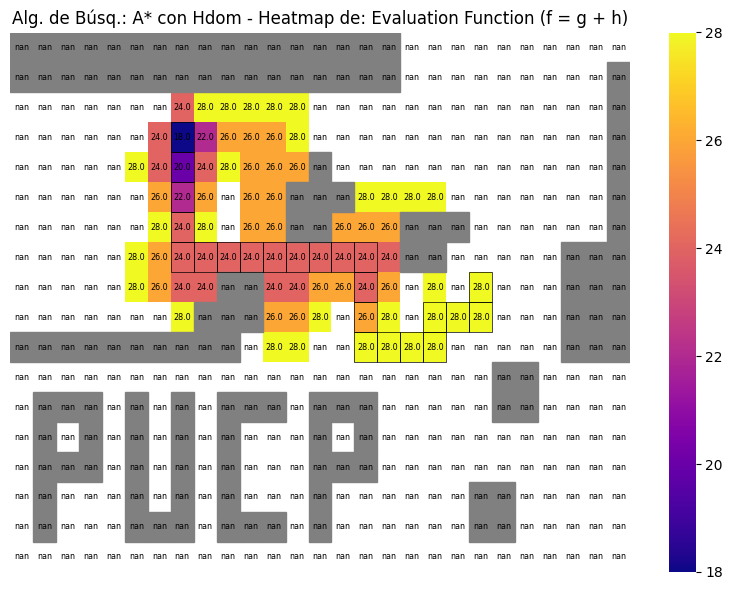

In [ ]:
costiGrid, heuriGrid = display_pathCosts_ofResults(maze, visited_nodes, nsol.path(), tipoDeBusq='A* con Hdom',
                                            valToPlot="evalFun", hFunc=h_dominante, addNumericVals=True)

#### busqueda A* con heurística weighted basada en straightline_dist

In [ ]:
nsol, visited_nodes = astar_search(p, h_weighted)
print('Solucion A* y heuristica W de straightline_dist: {}. Nodos visitados={}. Costo Solucion = {}'.format(nsol.solution(), len(visited_nodes),nsol.path_cost))
displayResults(maze, visited_nodes, nsol.path())

Solucion A* y heuristica W de straightline_dist: ['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'S', 'E', 'S', 'E', 'E', 'E', 'S', 'S', 'S']. Nodos visitados=25. Costo Solucion = 48
 --------------------------- 
|#################~~~~~~~~~~|
|#################    =~   #|
|     ~~~~    ==   =~==~   #|
|     ~~Sxxxxxxxxx ==~=~~  #|
|     ===~~  o#==xxoo~=~~  #|
|     ===~~  ### oxxxx     #|
|     ===~~  ##  o###x     #|
| =~             o## x   ###|
| =~      ##  == =~ =E   ###|
|      ==###  == =~      ###|
|##########   ==        ~###|
|~~~~~~~~         ~~~~##~   |
| ### # # ### ### ====##=   |
| # # # # #   # #   ==~~~=  |
| ### # # #   ###   =~~~==  |
| #   # # #   #     =##~    |
| #   ### ### #     =##     |
|~~~~~~~~~~~~~~~~~~~~~~~~~~~|
 --------------------------- 
x - celdas en la solucion
o - celdas visitadas durante la búsqueda
-------------------------------


##### Veamos los resultados de nuestro experimento

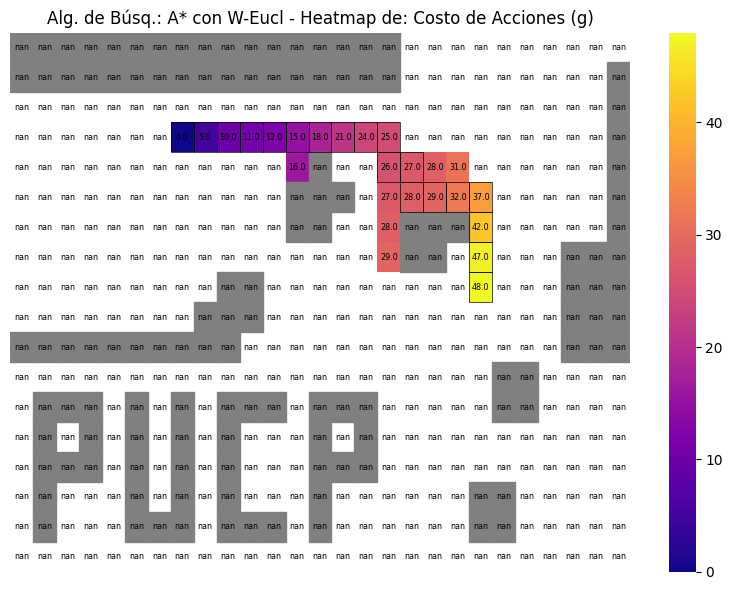

In [ ]:
costiGrid, heuriGrid = display_pathCosts_ofResults(maze, visited_nodes, nsol.path(), tipoDeBusq='A* con W-Eucl',
                                            valToPlot="cost", hFunc=h_weighted, addNumericVals=True)

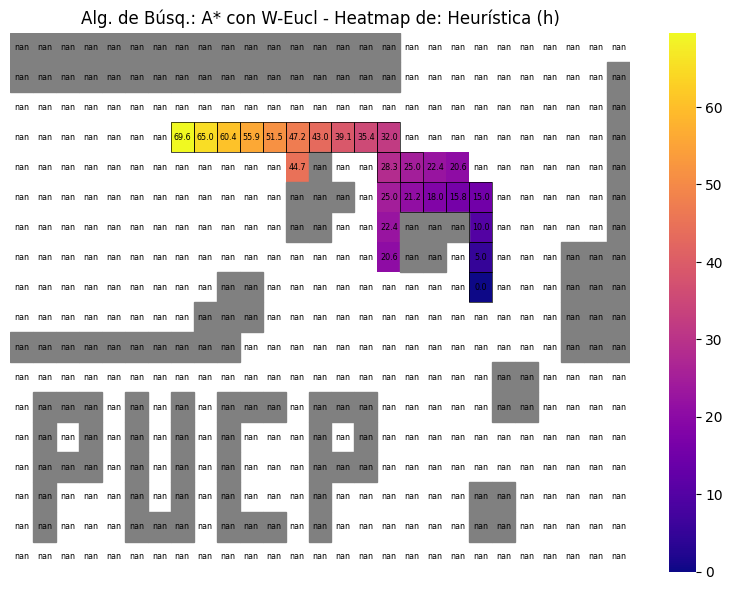

In [ ]:
costiGrid, heuriGrid = display_pathCosts_ofResults(maze, visited_nodes, nsol.path(), tipoDeBusq='A* con W-Eucl',
                                            valToPlot="heuristic", hFunc=h_weighted, addNumericVals=True)

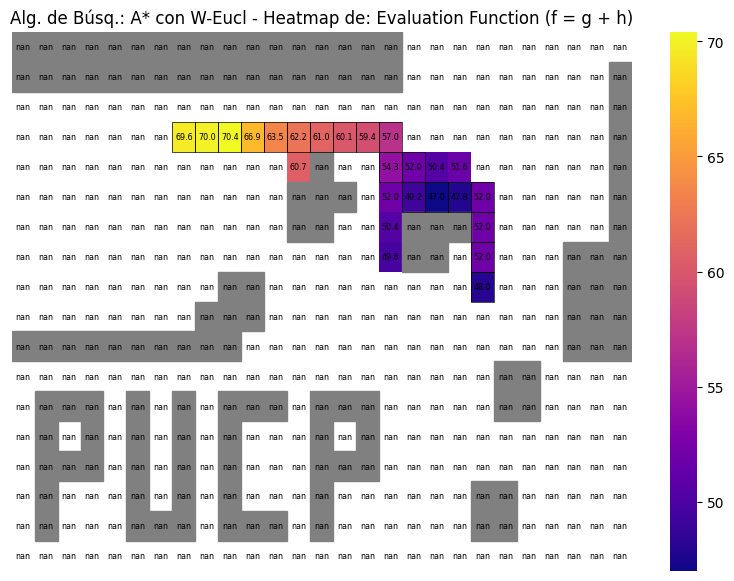

In [ ]:
costiGrid, heuriGrid = display_pathCosts_ofResults(maze, visited_nodes, nsol.path(), tipoDeBusq='A* con W-Eucl',
                                            valToPlot="evalFun", hFunc=h_weighted, addNumericVals=True)

## Desafío de la semana: Entorno `MazeEnvironment` con heurísticas (<font color='red'>20 puntos</font> en total)

1) Implementar las funciones `straightline_dist` y `manhatan_dist` (<font color='red'>3 puntos</font> por cada una).



2) Implementar la función `h_dominante` (<font color='red'>2 puntos</font>).

3) Implementar la función `greedy_search` (<font color='red'>2 puntos</font>).

Las celdas de códigos que debe completar para dar solución a las preguntas anteriores, están en la parte superior del cuadernillo.

---

4) En cuanto a las soluciones encontradas por A* utilizando las dos heurísticas (por separado), ¿siempre se encontrarán soluciones óptimas? ¿Por qué? Responder antes de realizar la siguiente pregunta (<font color='red'>2 puntos</font>).


Respuesta:

5) Indicar la diferencia (si es que la hay) entre *optimalidad de la solución encontrada* y *cantidad de nodos explorados* (<font color='red'>2 puntos</font>). Justificar su respuesta.

Respuesta:

6) Ejecutar en el mapa que está en el archivo `mapa_sesion3.txt` y escribir cuántos nodos visita el algoritmo A* con cada una de las heurísticas implementadas, así como el costo solución encontrado. Completar los datos en la siguiente tabla (<font color='red'>1 punto</font> por cada fila de la tabla):

El peso `W` de la heurística `h_weighted`, debe ser definido como `W=5`.



| A* en `mapa_sesion3.txt` | `straightline_dist` | `manhatan_dist` | `h_dominante` |`W_straightline_dist` |
| :------- | :------: | -----: | -----: |-----: |
| Costo del camino  | ?       | ?   | ?   |?   |
| Nodos visitados   | ?     |? |? |?   |


7) Ejecutar en el mapa que está en el archivo `mapa_sesion3.txt` y completar los datos en la siguiente tabla (<font color='red'>1 punto</font> por cada fila de la tabla):

| | BFS | DFS | UCS | Búsqueda codiciosa con `h_dominante`|
| :------- | :------: | -----: | -----: | -----: |
| Costo del camino  | ?       | ?   |?|?|
| Nodos visitados   | ?     | ? |?|?|


8) Por qué UCS obtuvo una solución con el mismo costo de camino que A* con heurísticas admisibles y consistentes? (<font color='red'>2 puntos</font>).


Respuesta: